# Introduction

### Due April 17th, 23:59

In this homework you will be implementing a LSTM model for POS tagging.

You are given the following files:
- `POS_NEMM.ipynb`: Notebook file for NEMM model (Optional)
- `POS_LTML.ipynb`: Notebook file for MTML model
- `train.txt`: Training set to train your model
- `test.txt`: Test set to report your model’s performance
- `tags.csv`: Treebank tag universe
- `sample_prediction.csv`: Sample file your prediction result should look like
- `utils/`: folder containing all utility code for the series of homeworks


### Deliverables (zip them all)

- pdf or html version of your final notebook
- Use the best model you trained, generate the prediction for test.txt, name the
output file prediction.csv (Be careful: the best model in your training set might not
be the best model for the test set).
- writeup.pdf: summarize the method you used and report their performance.
If you worked on the optional task, add the discussion. Add a short essay
discussing the biggest challenges you encounter during this assignment and
what you have learnt.

(**You are encouraged to add the writeup doc into your notebook
using markdown/html langauge, just like how this notes is prepared**)


<h1><center>HW05 Write up</center></h1>
<h2> POS LSTM </h2>

This part is fairly straightforward mostly because the framework has already been done by the instructor.

The architechure is simple, just use two bidirectional LSTMs with 100 units, it already has a high prediction power.

The LSTM predicts a 
ignore_accuracy: 0.9627 
sentence_accuracy: 0.5611 
val_ignore_accuracy: 0.9451
val_sentence_accuracy: 0.4566

It can get 95% more of the tokens POS right and half of the whole sentence correct.

<h2> Optional POS MEMM </h2>

This part requires more coding and algorithm knowledge, so more challenging. 

I spend few hours on the viterbi algorithm implementation, and I think I learnt more about the dynamics programming

and I also found it is not only used in the POS tagging, but also a lot of other areas like DNA sequencing, also, 

this notebook problem is not "hidden", it is pretty extensible to Hidden Markov Model, just adding another 

probability matrix.

The training of MEMM takes a lot of time and it actually does not do as well as the LSTM one. It only uses 

information in the context but not the whole history, and it is not optimized for speed.

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import sparse

# add utils folder to path
p = os.path.dirname(os.getcwd())
if p not in sys.path:
    sys.path = [p] + sys.path
    
from utils.hw5 import load_data, save_prediction, ignore_class_accuracy, whole_sentence_accuracy
from utils.general import show_keras_model

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

`tags` is a dictionary that maps the [Treebank tag](https://www.clips.uantwerpen.be/pages/mbsp-tags) to its numerical encoding. There are 45 tags in total, plus a special tag `START (tags[-1])` to indicate the beginning of a sentence. 

In [2]:
tags = list(pd.read_csv('tags.csv', index_col=0).tag_encode.keys())

train, train_label = load_data("train.txt")
train, dev, train_label, dev_label = train_test_split(train, train_label)
test, _ = load_data("test.txt")

print("Training set: %d" % len(train))
print("Dev set: %d" % len(dev))
print("Testing set: %d" % len(test))

Training set: 33539
Dev set: 11180
Testing set: 9955


# LSTM

In [3]:
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

class POS_LSTMM:
    """
    To help you focus on the LSTM model, I have made most part of the code ready, make sure you
    read all the parts to understand how the code works. You only need to modify the prepare method 
    to add the RNN model.
    """
    def __init__(self, tag_vocab=tags, max_sent_len=40, 
                 voc_min_freq=5, **kwargs):
        """
        input: 
            tag_vocab: tag dictionary, you will less likely need to change this
            voc_min_freq: use this to truncate low frequency vocabulary
            max_sent_len: truncate/pad all sentences to this length
            
            kwargs: Use as needed to pass extra parameters
        """
        self.vocab = []
        self.reverse_vocab = {}
        self.tag_vocab = tag_vocab
        self.reverse_tag_vocab = {k:v for v, k in enumerate(tag_vocab)}
        self._voc_min_freq = voc_min_freq
        self._max_sent_len = max_sent_len

        """
        Feel free to add code here as you need
        """

    def collect_vocab(self, X):
        """
        Create vocabulary from all input data
        input:
            X: list of sentences
        """
        vocab = Counter([t for s in X for t in s])
        vocab = {k: v for k, v in vocab.items() if v > self._voc_min_freq}
        vocab = ["<PAD>", "<UNK>"] + sorted(vocab, key=lambda x: vocab[x], reverse=True)
        reverse_vocab = {k: v for v, k in enumerate(vocab)}
        
        return vocab, reverse_vocab
                
    def transform_X(self, X):
        """
        Translate input raw data X into trainable numerical data
        input:
            X: list of sentences
        """
        X_out = []
        
        for sent in X:
            X_out.append([self.reverse_vocab.get(t, 0) for t in sent])
            
        X_out = pad_sequences(sequences=X_out, maxlen=self._max_sent_len, 
                              padding='post', truncating='post',
                              value=self.reverse_vocab['<PAD>'])
        
        return X_out
    
    def transform_Y(self, Y):
        """
        Translate input raw data Y into trainable numerical data
        input:
            y: list of list of tags
        """
        Y_out = [] 
        
        for labs in Y:
            Y_out.append([self.reverse_tag_vocab[lab] for lab in labs])
            
        Y_out = pad_sequences(sequences=Y_out, maxlen=self._max_sent_len, 
                              padding='post', truncating='post',
                              value=self.reverse_tag_vocab['<PAD>'])
        
        return Y_out
    
    def prepare(self, X, Y):
        """
        input:
            X: list of sentences
            y: list of list of tags
        """
        self.vocab, self.reverse_vocab = self.collect_vocab(X)
        X, Y = self.transform_X(X), self.transform_Y(Y)
        
        model = Sequential()
        """
        Write your own model here
        Hints:
            - Rember to use embedding layer at the beginning
            - Use Bidrectional LSTM to take advantage of both direction history  
        """
        
        model.add(Embedding(input_dim=len(self.vocab),output_dim=100,input_length=self._max_sent_len))
        model.add(Bidirectional(LSTM(100, return_sequences=True)))
        model.add(Bidirectional(LSTM(100, return_sequences=True)))
        model.add(TimeDistributed(Dense(len(self.tag_vocab),activation="softmax")))

        """
        You can read the source code to understand how ignore_class_accuracy works.
        The reason of using this customized metric is because we have padded the training 
        data with lots of '<PAD>' tag. It's easy and useless to predict this tag, we need 
        to ignore this tag when calculate the accuracy.
        """
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy', 
                               ignore_class_accuracy(self.reverse_tag_vocab['<PAD>']),
                               whole_sentence_accuracy(self.reverse_tag_vocab['<PAD>'])])

        self.model = model
        
        return self
        
        
    def fit(self, X, Y, batch_size=128, epochs=10):
        X, Y = self.transform_X(X), self.transform_Y(Y)
        self.model.fit(X, to_categorical(Y, num_classes=len(self.tag_vocab)),
                       batch_size=batch_size, 
                       epochs=epochs, validation_split=0.2)

        return self

    def predict(self, X):
        results = []
        X_new = self.transform_X(X)
        Y_pred = self.model.predict_classes(X_new)
    
        for i, y in enumerate(Y_pred):
            results.append(
                [self.tag_vocab[y[j]] for j in range(min(len(X[i]), len(X_new[i])))]
            )
            
        return results

W0412 17:38:26.223311 4629745088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0412 17:38:26.276912 4629745088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0412 17:38:26.282796 4629745088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0412 17:38:29.161601 4629745088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0412 17:38:29.186764 4629745088 deprecation_wrapper.py:119] From /usr/local

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           809100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 200)           160800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 200)           240800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 47)            9447      
Total params: 1,220,147
Trainable params: 1,220,147
Non-trainable params: 0
_________________________________________________________________


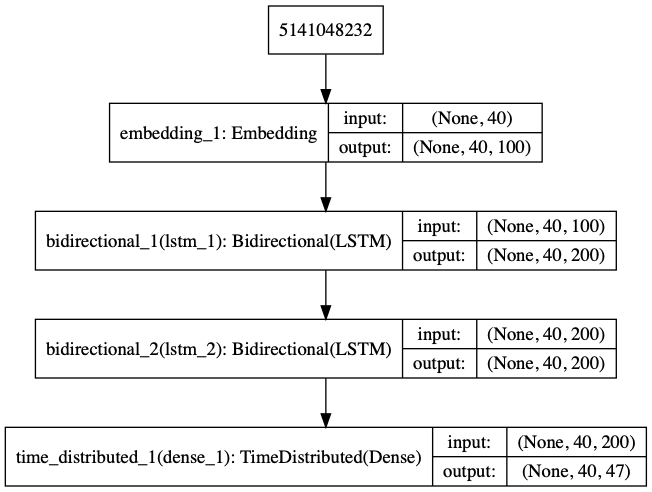

In [4]:
lstm = POS_LSTMM().prepare(train, train_label)
lstm.model.summary()
show_keras_model(lstm.model)

In [5]:
lstm = POS_LSTMM().prepare(train, train_label)
lstm.fit(train, train_label)

W0412 17:38:38.322596 4629745088 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0412 17:38:46.296940 4629745088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 26831 samples, validate on 6708 samples
Epoch 1/10
26831/26831 [==============================] - 178s 7ms/step - loss: 1.4483 - acc: 0.6135 - ignore_accuracy: 0.1679 - sentence_accuracy: 0.0059 - val_loss: 0.8909 - val_acc: 0.7580 - val_ignore_accuracy: 0.4741 - val_sentence_accuracy: 0.0507
Epoch 2/10
26831/26831 [==============================] - 164s 6ms/step - loss: 0.3965 - acc: 0.8948 - ignore_accuracy: 0.7730 - sentence_accuracy: 0.1496 - val_loss: 0.1690 - val_acc: 0.9588 - val_ignore_accuracy: 0.9103 - val_sentence_accuracy: 0.2944
Epoch 3/10
26831/26831 [==============================] - 138s 5ms/step - loss: 0.1277 - acc: 0.9665 - ignore_accuracy: 0.9273 - sentence_accuracy: 0.3587 - val_loss: 0.1098 - val_acc: 0.9695 - val_ignore_accuracy: 0.9336 - val_sentence_accuracy: 0.3939
Epoch 4/10
26831/26831 [==============================] - 144s 5ms/step - loss: 0.0952 - acc: 0.9724 - ignore_accuracy: 0.9402 - sentence_accuracy: 0.4201 - val_loss: 0.0943 - val_acc: 0.97

## Save your model prediction

In [6]:
prediction = lstm.predict(test)
save_prediction(prediction)